In [1]:
# Notes:

# The unet performance was not reliable in previous testing.
# Potential reasons were the choice of loss function, activation functions, batch-size + batch-normalization in deeper network.

# While batch-normalization seemed to help, it is not desirable because
# 1. we are working with small batch sizes
# 2. some entries remain close to zero throughout (particular channels across time)
# 3. batch-norm treats each timepoint as a separate feature, which is not appropriate for this dataset

# Stripping down the model to a single conv layer, and overfitting
# on a single batch showed that in the absence of any normalization, convergence is
# 1. slow
# 2. sensitive to learning rates (and therefore unstable at times)

# Layer normalization of the input seems to fix all the above issues.
# We'll test Whether normalization only at the input of the unet is sufficient, or whether this is needed in deeper layers as well.

import numpy as np
import torch
import torch.nn as nn
from timebudget import timebudget

from torch.utils.data import DataLoader, Subset
from sourcesep.models.helpers import H5Dataset
from sourcesep.utils.config import load_config

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

# get filenames
paths = load_config(dataset_key="all")
sim_name = "2023-03-08"
h5_filename = str(paths["root"] / "sims" / f"{sim_name}.h5")

# get single batch
dataset = H5Dataset(h5_filename=h5_filename, n_timesamples=2048)
subset = Subset(dataset, np.array([1, 1000]))
batch = next(iter(DataLoader(subset, batch_size=2, num_workers=1, pin_memory=True)))

Paths are for dataset tagged: all


In [2]:
model_norm = nn.Sequential(
    nn.LayerNorm(2048), nn.Conv1d(in_channels=300, out_channels=3, kernel_size=3, padding="valid"), nn.Tanh()
)

model_simple = nn.Sequential(nn.Conv1d(in_channels=300, out_channels=3, kernel_size=3, padding="valid"), nn.Tanh())

pad = 1


def loss_A(input, target):
    return nn.functional.smooth_l1_loss(input, target, beta=0.2)


def A_transform(x):
    return 5 * (x - 1)


def A_transform_inv(x):
    return (1.0 / 5.0) * (x) + 1.0


def crop_batch(batch, pad):
    batch_cropped = {}
    batch_cropped["A"] = batch["A"][:, :, pad:-pad]
    batch_cropped["H_ox"] = torch.squeeze(batch["H_ox"][:, :, pad:-pad])
    batch_cropped["H_dox"] = torch.squeeze(batch["H_dox"][:, :, pad:-pad])
    batch_cropped["M"] = torch.squeeze(batch["M"][:, :, pad:-pad])
    batch_cropped["N"] = batch["N"][:, :, pad:-pad]
    batch_cropped["O"] = batch["O"][:, :, pad:-pad]
    return batch_cropped

In [3]:
def fit_test(model, batch):
    loss_list = []
    step_list = []
    getx = lambda x: x.detach().cpu().numpy()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch["O"] = batch["O"].to(device)
    batch["A"] = batch["A"].to(device)

    optimizer = torch.optim.Adam(model.parameters())

    for step in range(1000):
        optimizer.zero_grad()
        Ar = model(batch["O"])
        batch_cropped = crop_batch(batch, pad)

        loss_A0 = loss_A(Ar[:, 0, :], A_transform(batch_cropped["A"][:, 0, :]))
        loss_A1 = loss_A(Ar[:, 1, :], A_transform(batch_cropped["A"][:, 1, :]))
        loss_A2 = loss_A(Ar[:, 2, :], A_transform(batch_cropped["A"][:, 2, :]))
        loss = loss_A0 + loss_A1 + loss_A2

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        step_list.append(step)

    f, ax = plt.subplots(3, 1, figsize=(4, 4))
    for i in range(3):
        batch_idx = 0
        data = getx(A_transform(torch.squeeze(batch_cropped["A"][batch_idx, i, :])))
        pred = getx(torch.squeeze(Ar[batch_idx, i, :]))

        ax[i].plot(data, label="data", c="dodgerblue", alpha=0.8)
        ax[i].plot(pred, label="pred", c="crimson", alpha=0.5)
        ax[i].legend()

    return f, ax, loss_list, step_list

training simple model took 5.321sec


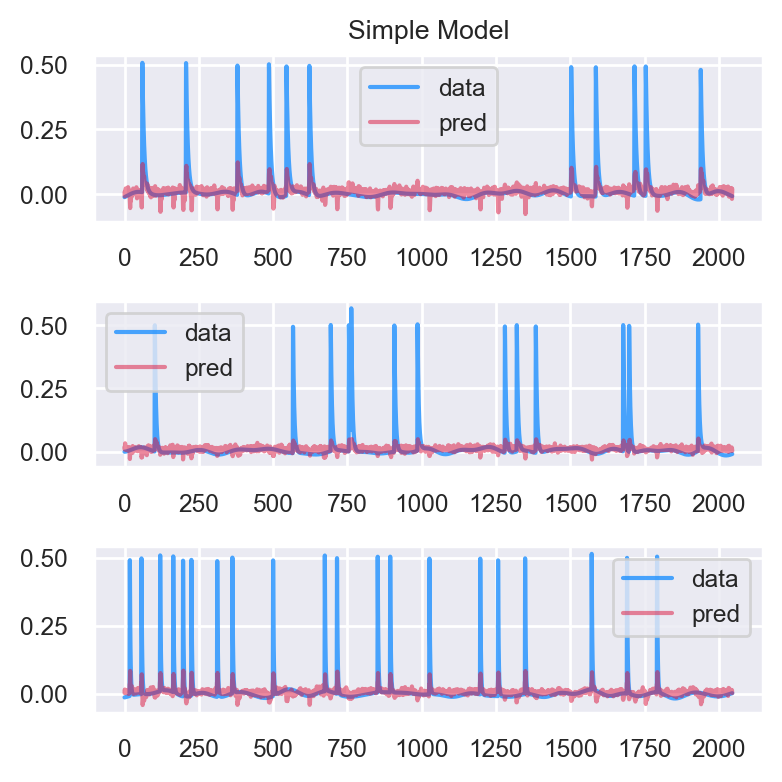

training model with normalization took 4.895sec


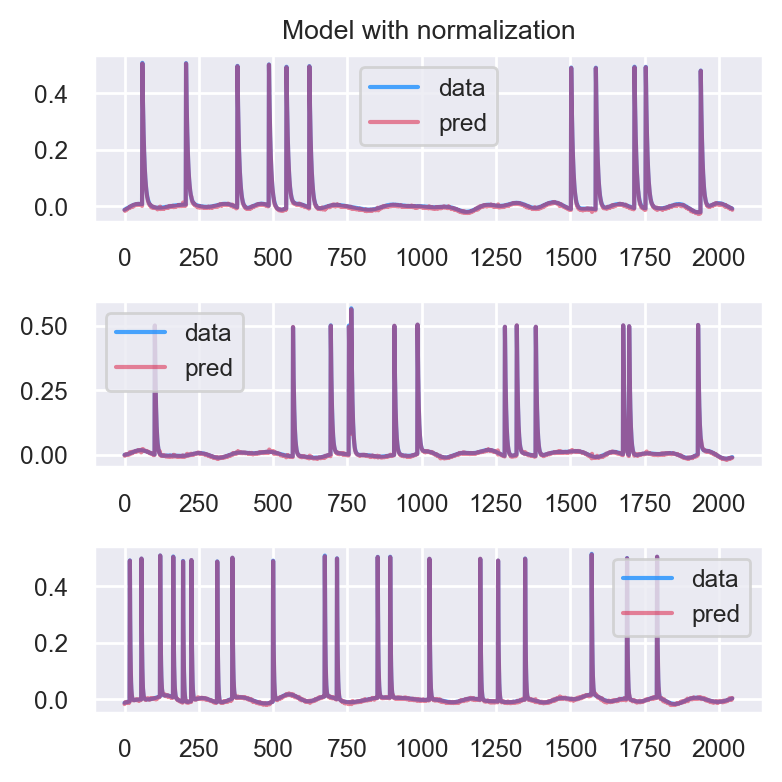

In [4]:
with timebudget("training simple model"):
    f, ax, loss_list_simple, step_list = fit_test(model_simple, batch)
ax[0].set(title="Simple Model")
plt.tight_layout()
plt.show()

with timebudget("training model with normalization"):
    f, ax, loss_list_norm, step_list = fit_test(model_norm, batch)
ax[0].set(title="Model with normalization")
plt.tight_layout()
plt.show()

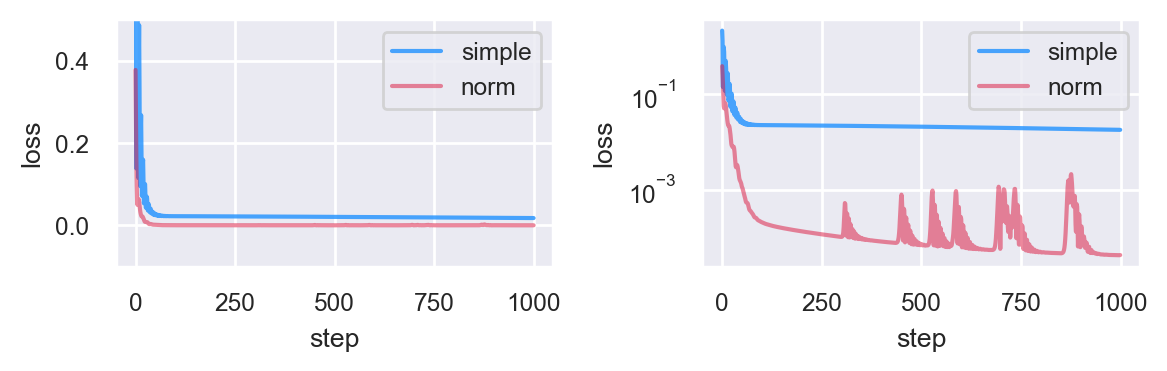

In [5]:
f, ax = plt.subplots(1, 2, figsize=(6, 2))

ax[0].plot(step_list, loss_list_simple, label="simple", c="dodgerblue", alpha=0.8)
ax[0].plot(step_list, loss_list_norm, label="norm", c="crimson", alpha=0.5)
ax[0].set(xlabel="step", ylabel="loss", ylim=(-0.1, 0.5))
ax[0].legend()

ax[1].plot(step_list, loss_list_simple, label="simple", c="dodgerblue", alpha=0.8)
ax[1].plot(step_list, loss_list_norm, label="norm", c="crimson", alpha=0.5)
ax[1].set(xlabel="step", ylabel="loss", yscale="log")
ax[1].legend()

plt.tight_layout()
plt.show()

In [1]:
import torch.nn as nn

# example with layer norm
x = torch.randn(10, 4, 5)
layer = nn.LayerNorm((4, 5))

y = layer(x)
print(f"before {torch.mean(x[0,:,:])}")
print(f"after {torch.mean(y[0,:,:])}")
layer.weight

before 0.3557329773902893
after -5.9604645663569045e-09


Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)